In [12]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [13]:
# import the data
bikes = pd.read_csv('train.csv', index_col=0, parse_dates=True)
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [14]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [15]:
bikes.notna().sum()
# the NaN shown are the related ot the missing data that we must fill in in th eend of each month!

season        10886
holiday       10886
workingday    10886
weather       10886
temp          10886
atemp         10886
humidity      10886
windspeed     10886
casual        10886
registered    10886
count         10886
dtype: int64

In [27]:
# In order to include the correlations from timestamp I will introduce new columns:
bikes['day'] = bikes.index.day
bikes['month'] = bikes.index.month
bikes.head(2)
#bikes['day'].unique()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,day,countLog,month
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0,16,1,1.20412,1
2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0,40,1,1.60206,1


In [22]:
bikes['countLog'] = np.log10(bikes['count'])

In [ ]:
bikes = bikes.drop(columns=['registered','casual','temp'])

# Explre Data Analysis

1. $\color{yellow}{\text{Check feature correlations and feature time dependence with groupby to see relation per dax for different years}}$

- $\color{red}{\text{Day}}$

In [24]:
day =bikes.groupby(['day']).mean()
day.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,countLog
day,,,,,,,,,
1,2.502609,0.0,0.666087,1.516522,24.271313,65.066087,11.057622,180.333913,1.960543


<AxesSubplot:xlabel='day', ylabel='count'>

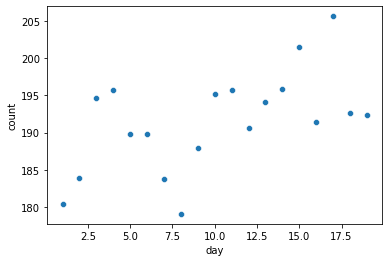

In [25]:
# check the statistsics of the different datasets

sns.scatterplot(x = day.index, y =day['count'])

In [44]:
day_month = bikes.groupby(['day','month']).mean()
day_month.head(2)

season  holiday  workingday   weather      atemp   humidity  \
day month                                                                
1   1         1.0      0.0         0.0  1.458333  18.481146  74.916667   
    2         1.0      0.0         1.0  1.744681  17.650106  66.531915   

           windspeed       count  countLog  
day month                                   
1   1      11.812519   68.312500  1.546958  
    2       8.213202  126.361702  1.732749

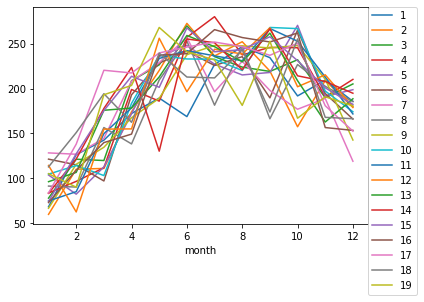

In [45]:
daysMonths =day_month["count"].unstack(level=0).plot.line()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

- - $\color{green}{\text{Fit a Poly Regression model }}$

In [50]:
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [51]:
#Determine the X and y
X = pd.DataFrame(day.index)
y = day['count']

In [52]:
# Fit the data with a ppolynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly


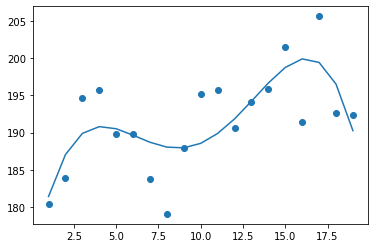

In [57]:
y_pred_poly, X_poly = fit_with_poly(X,y,4)
plt.scatter(X,y)
plt.plot(X,y_pred_poly)


- - $\color{green}{\text{Regularization }}$

In [58]:
def lasso_regularization(X,y):
    lasso = Lasso(alpha = 0.01,max_iter = 1000)
    lasso.fit(X, y)
    y_lasso = lasso.predict(X)
    print(lasso.coef_)
    return y_lasso

[ 0.         -0.3768377   0.02768032  0.00999613 -0.00049732]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+02, tolerance: 8.042e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


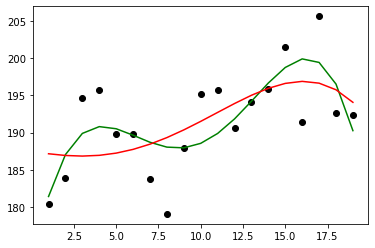

In [59]:
y_lasso = lasso_regularization(X_poly,y)
plt.scatter(X, y, label='actual',color='black')
plt.plot(X, y_pred_poly, label='poly',color = 'green')
plt.plot(X, y_lasso, label='lasso',color = 'red')


- - $\color{green}{\text{GridSearchCV}}$


In [60]:
def optimGScv(X,y,a,b):
    my_pipe = Pipeline([
        ['my_poly_engineering', PolynomialFeatures(degree=2)],
        ['my_lasso', Lasso(max_iter=5000)]
    ])
    my_pipe.fit(X, y)
    parameter_grid = {
        'my_poly_engineering__degree': np.arange(a,b).tolist(),
        'my_lasso__alpha': [0.001, 0.01, 0.1 ]
    }
    gridsearch = GridSearchCV(my_pipe, 
                          parameter_grid, 
                          scoring=None,
                          verbose=1)
    gridsearch.fit(X,y)
    bp = gridsearch.best_params_
    score = gridsearch.best_estimator_.score(X,y)

    y_pred_est = gridsearch.best_estimator_.predict(X)

    return y_pred_est, score, bp

In [61]:
y_pred_est , score_GSCV, best_parameter = optimGScv(X,y,2,5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+02, tolerance: 5.831e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+02, tolerance: 5.419e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

Score : 0.30523394532529646 {'my_lasso__alpha': 0.1, 'my_poly_engineering__degree': 2}


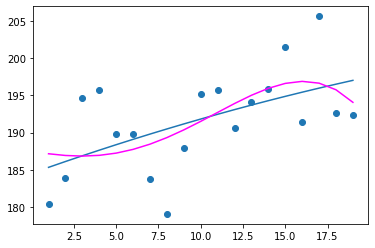

In [62]:
plt.scatter(X,y, )
plt.plot(X,y_pred_est, )
plt.plot(X, y_lasso,color='magenta')
print('Score :',score_GSCV, best_parameter)

# 2. Results
- days have no periodic behaviour and we should treat it as a simpole categorical feature with OHE.